In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os,sys
import PIL
import tensorflow as tf
from PIL import Image

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [6]:
full_dir = "E:/rice_plant"
p = os.listdir('E:/rice_plant/Phosphorus(P)')
n = os.listdir('E:/rice_plant/Nitrogen(N)')
k = os.listdir('E:/rice_plant/Potassium(K)')
nlist =[]
plist=[]
klist =[]
for ne in n  :
    nlist.append(os.path.join("E:/rice_plant/Nitrogen(N)/",ne))
for ne in p  :
    plist.append(os.path.join("E:/rice_plant/Phosphorus(P)/",ne))
for ne in k  :
    klist.append(os.path.join("E:/rice_plant/Potassium(K)/",ne))
print(nlist[0], plist[0], klist[0])

#PIL.Image.open(nlist[0])

#PIL.Image.open(plist[0])
#PIL.Image.open(klist[0])

import cv2 

from matplotlib import pyplot as plt
i =0





E:/rice_plant/Nitrogen(N)/untitled-1.JPG E:/rice_plant/Phosphorus(P)/IMG_3784.JPG E:/rice_plant/Potassium(K)/untitled-1.JPG


In [10]:
img = Image.open("E:/1.png")
img =np.array(img)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
th, threshed = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)


    ## (2) Morph-op to remove noise
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
morphed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, kernel)

    ## (3) Find the max-area contour
cnts = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
cnt = sorted(cnts, key=cv2.contourArea)[-1]

    ## (4) Crop and save it
x,y,w,h = cv2.boundingRect(cnt)
dst = img[y:y+h, x:x+w]
cv2.imwrite("E:/User Document/001.png", dst)

True

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  full_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1156 files belonging to 3 classes.
Using 1041 files for training.


In [19]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  full_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1156 files belonging to 3 classes.
Using 115 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['Nitrogen(N)', 'Phosphorus(P)', 'Potassium(K)']


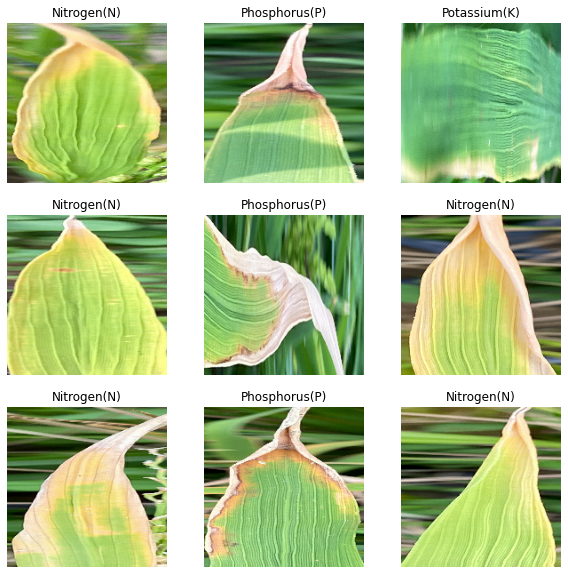

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [21]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [22]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [23]:
normalization_layer = layers.Rescaling(1./255)

In [24]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image)) 



data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])


0.0 1.0


In [33]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])




In [34]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 45, 45, 64)       

In [66]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
33/33 [==============================] - 13s 383ms/step - loss: 1.2208 - accuracy: 0.3823 - val_loss: 1.0798 - val_accuracy: 0.3217
Epoch 2/10
33/33 [==============================] - 12s 367ms/step - loss: 0.8819 - accuracy: 0.6023 - val_loss: 0.8120 - val_accuracy: 0.6087
Epoch 3/10
33/33 [==============================] - 12s 365ms/step - loss: 0.6227 - accuracy: 0.7253 - val_loss: 0.5826 - val_accuracy: 0.7565
Epoch 4/10
33/33 [==============================] - 12s 360ms/step - loss: 0.4622 - accuracy: 0.8204 - val_loss: 0.4941 - val_accuracy: 0.8000
Epoch 5/10
33/33 [==============================] - 12s 367ms/step - loss: 0.3647 - accuracy: 0.8617 - val_loss: 0.5415 - val_accuracy: 0.7739
Epoch 6/10
33/33 [==============================] - 12s 366ms/step - loss: 0.2474 - accuracy: 0.9059 - val_loss: 0.5239 - val_accuracy: 0.8000
Epoch 7/10
33/33 [==============================] - 12s 364ms/step - loss: 0.1811 - accuracy: 0.9347 - val_loss: 0.5197 - val_accuracy: 0.7913

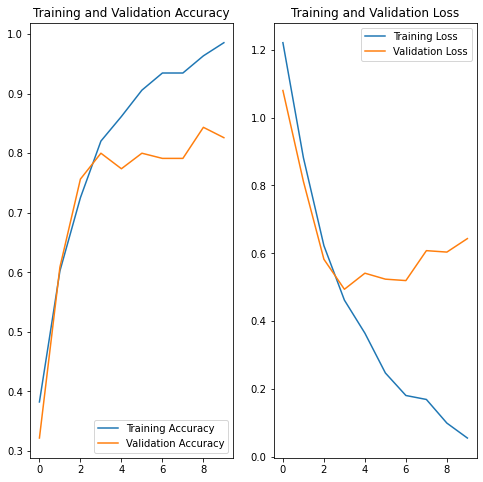

In [105]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()





def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(180, 180))
    #img = img1.Rescaling(1./255, input_shape=(img_height, img_width, 3))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 1./255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


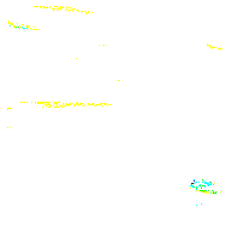

[[-117.438194 -362.72263   270.4138  ]]


In [108]:

img = load_image(klist[0], True)
#predict = model.predict(img)
print(model.predict(img))
